In [31]:
import numpy as np
import pandas as pd

In [32]:
df = pd.read_csv("input/ocular-disease-recognition-odir5k/full_df.csv")

In [33]:
df.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [35]:
def is_normal(text):
    if "normal fundus" in text:
        return 1
    else:
        return 0

In [36]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = df.loc[(df.C ==1) & (df['left_cataract'] == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C ==1) & (df['right_cataract'] == 1)]["Right-Fundus"].values

In [37]:
df["left_normal"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_normal(x))
df["right_normal"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_normal(x))
left_normal = df.loc[(df.N ==1) & (df["left_normal"] == 1)]["Left-Fundus"].sample(250, random_state=42).values
right_normal = df.loc[(df.N ==1) & (df['right_normal'] == 1)]["Right-Fundus"].sample(250, random_state=42).values


In [38]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


print(len(cataract))
print(len(normal))

594
500


In [39]:
from tqdm import tqdm
import cv2
import os, random

dataset_dir = "input/ocular-disease-recognition-odir5k/preprocessed"
labels = []
dataset = []
image_size=256
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [40]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:08<00:00, 69.75it/s] 


In [41]:
len(dataset)

570

In [42]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:15<00:00, 32.32it/s]


In [43]:
len(dataset)

1020

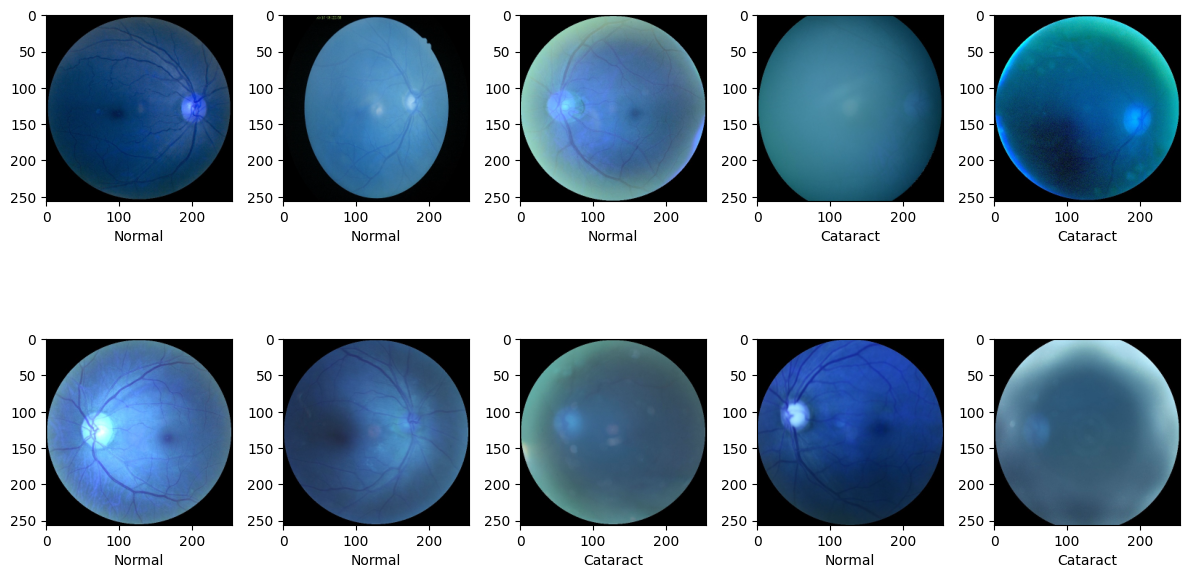

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [45]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=45)

In [47]:
from tensorflow.keras import Sequential, layers

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 128)     

In [49]:
from tensorflow.keras import metrics

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_test, y_test), verbose=1)

Epoch 1/25
13/13 [==============================] - 86s 7s/step - loss: 0.2451 - accuracy: 0.9142 - val_loss: 0.3081 - val_accuracy: 0.8775
Epoch 2/25
13/13 [==============================] - 86s 7s/step - loss: 0.2552 - accuracy: 0.8995 - val_loss: 0.3057 - val_accuracy: 0.8873
Epoch 3/25
13/13 [==============================] - 86s 7s/step - loss: 0.2089 - accuracy: 0.9228 - val_loss: 0.3161 - val_accuracy: 0.8873
Epoch 4/25
13/13 [==============================] - 86s 7s/step - loss: 0.2074 - accuracy: 0.9154 - val_loss: 0.4982 - val_accuracy: 0.8186
Epoch 5/25
13/13 [==============================] - 86s 7s/step - loss: 0.2363 - accuracy: 0.9118 - val_loss: 0.3004 - val_accuracy: 0.8971
Epoch 6/25
13/13 [==============================] - 87s 7s/step - loss: 0.2073 - accuracy: 0.9314 - val_loss: 0.2717 - val_accuracy: 0.9216
Epoch 7/25
13/13 [==============================] - 86s 7s/step - loss: 0.1808 - accuracy: 0.9289 - val_loss: 0.2227 - val_accuracy: 0.9167
Epoch 8/25
13/13 [==

In [54]:
loss, accuracy = model.evaluate(x_test,y_test)
print("loss: ",loss)
print("Accuracy: ",accuracy)
#print("Precision:", precision)
#print("Recall: ", recall)
#print("F1 Score: ", f1_score)

7/7 [==============================] - 5s 663ms/step - loss: 0.1420 - accuracy: 0.9559
loss:  0.1419590562582016
Accuracy:  0.9558823704719543
